Setup + imports

In [1]:
!pip -q install datasets

import os, time, json, math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM


Utils : params, latence, PPL zip-style

In [2]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

@torch.no_grad()
def measure_latency_ms_per_token(model, tokenizer, prompt="Write a short paragraph about pruning.", gen_tokens=64, warmup=1):
    model.eval()
    device = next(model.parameters()).device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # warmup
    for _ in range(warmup):
        _ = model.generate(**inputs, max_new_tokens=gen_tokens, do_sample=False)

    torch.cuda.synchronize() if device.type == "cuda" else None
    t0 = time.time()
    _ = model.generate(**inputs, max_new_tokens=gen_tokens, do_sample=False)
    torch.cuda.synchronize() if device.type == "cuda" else None
    t1 = time.time()

    ms_total = (t1 - t0) * 1000.0
    return ms_total / float(gen_tokens)

@torch.no_grad()
def compute_ppl_wikitext2_zip_style(
    model,
    tokenizer,
    split="test",
    seq_len=1024,
    stride=512,
    max_windows=256,
):
    """
    Zip-style PPL:
    - concat wikitext2
    - sliding window
    - mask overlap (labels=-100) so we don't double-count tokens
    - weighted NLL sum / token count
    """
    model.eval()
    ds = load_dataset("wikitext", "wikitext-2-raw-v1", split=split)

    text = "\n\n".join(ds["text"])
    enc = tokenizer(text, return_tensors="pt")
    input_ids = enc["input_ids"][0]

    device = next(model.parameters()).device
    input_ids = input_ids.to(device)

    nll_sum = 0.0
    tok_count = 0
    nb = 0

    for start in range(0, input_ids.numel() - 1, stride):
        end = min(start + seq_len, input_ids.numel())
        x = input_ids[start:end].unsqueeze(0)

        labels = x.clone()
        if start > 0:
            overlap = min(stride, labels.size(1))
            labels[:, :-overlap] = -100

        out = model(input_ids=x, labels=labels, use_cache=False, return_dict=True)
        n_eval = (labels != -100).sum().item()

        nll_sum += out.loss.detach().float().item() * max(n_eval, 1)
        tok_count += n_eval

        nb += 1
        if nb >= max_windows or end == input_ids.numel():
            break

    ppl = float(torch.exp(torch.tensor(nll_sum / max(tok_count, 1))).item())
    return ppl


Définir les modèles à évaluer (tu changeras les paths)

In [3]:
BASE_OUT = "/kaggle/working/semantic-llm-pruning"

# Remplis ces paths quand tu me les donnes
MODELS = [
    ("heads20_mlp10_lora_merged", "/kaggle/input/04-recovery-lora/semantic-llm-pruning/models/heads20_mlp10_lora_merged"),
    ("heads20_mlp20_lora_merged", "/kaggle/input/04-recovery-lora/semantic-llm-pruning/models/heads20_mlp20_lora_merged"),
    ("heads20", "/kaggle/input/02-structured-head-pruning-qo-gqa/semantic-llm-pruning/models/pruned_heads_20"),
    
]

assert len(MODELS) > 0, "Ajoute tes modèles dans MODELS (je remplirai quand tu me donneras les paths)."


Évaluer et logger → CSV

In [4]:
import pandas as pd

df_baseline = pd.read_csv(
    "/kaggle/input/00-setup-01-baseline-and-importance/semantic-llm-pruning/results/ablation_studies/baseline.csv"
)

df_head = pd.read_csv(
    "/kaggle/input/02-structured-head-pruning-qo-gqa/semantic-llm-pruning/results/ablation_studies/head_pruning.csv"
)

df_mlp = pd.read_csv(
    "/kaggle/input/03-structured-mlp-pruning-activation-based/semantic-llm-pruning/results/ablation_studies/mlp_pruning.csv"
)

df_all_existing = pd.concat([df_baseline, df_head, df_mlp], ignore_index=True)


In [5]:
!pip -q install --no-deps "protobuf<5"
!pip -q install -q sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.2 MB/s eta 0:00:00a 0:00:01


In [6]:
OUT_CSV = f"{BASE_OUT}/results/ablation_studies/final_eval.csv"
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)

rows = []

for item in MODELS:
    # accepte tuple (tag, path) ou dict {"tag":..., "path":...}
    if isinstance(item, (tuple, list)):
        tag, path = item
        group = ""
    else:
        tag = item["tag"]
        path = item["path"]
        group = item.get("group", "")


    assert os.path.isdir(path), f"Model path not found: {path}"

    tok = AutoTokenizer.from_pretrained(path, use_fast=True, local_files_only=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    model = AutoModelForCausalLM.from_pretrained(path, torch_dtype=torch.float16, local_files_only=True).to("cuda").eval()

    ppl = compute_ppl_wikitext2_zip_style(model, tok, split="test", seq_len=1024, stride=512, max_windows=256)
    lat = measure_latency_ms_per_token(model, tok, gen_tokens=64, warmup=1)
    params = count_params(model)

    row = {
        "tag": tag,
        "group": group,
        "path": path,
        "ppl": float(ppl),
        "latency_ms_per_token": float(lat),
        "params": int(params),
        "dtype": str(next(model.parameters()).dtype).replace("torch.", ""),
        "gpu": torch.cuda.get_device_name(0) if torch.cuda.is_available() else None,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    }
    rows.append(row)

    print(f"[{tag}] PPL={ppl:.3f} | latency={lat:.2f} ms/token | params={params:,}")

df_recovered = pd.DataFrame(rows)
df_recovered.to_csv(OUT_CSV, index=False)
print("Saved ->", OUT_CSV)
df_recovered
df = pd.concat([df_all_existing, df_recovered], ignore_index=True)
df.to_csv(
    "/kaggle/working/semantic-llm-pruning/results/ablation_studies/final_eval.csv",
    index=False
)


`torch_dtype` is deprecated! Use `dtype` instead!
2026-01-07 11:38:59.872602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767785940.060198      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767785940.111762      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767785940.560140      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767785940.560161      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767785940.560164      55

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

[heads20_mlp10_lora_merged] PPL=11.622 | latency=26.58 ms/token | params=971,909,120
[heads20_mlp20_lora_merged] PPL=13.247 | latency=27.41 ms/token | params=895,809,536
[heads20] PPL=13.720 | latency=26.81 ms/token | params=1,048,143,872
Saved -> /kaggle/working/semantic-llm-pruning/results/ablation_studies/final_eval.csv


Ajouter baseline params/PPL pour calculer compression (si baseline dans MODELS)

In [7]:
# baseline = le tag qui contient "baseline" (simple heuristique)
baseline_candidates = df[df["tag"].fillna("").astype(str).str.contains("baseline", case=False, regex=False)]

if len(baseline_candidates) == 0:
    print("⚠️ Pas de baseline dans MODELS => compression% sera NaN.")
    df["params_ratio_vs_baseline"] = np.nan
    df["params_compression_%"] = np.nan
else:
    b = baseline_candidates.iloc[0]
    b_params = float(b["params"])
    df["params_ratio_vs_baseline"] = df["params"] / b_params
    df["params_compression_%"] = (1.0 - df["params_ratio_vs_baseline"]) * 100.0

df


,model,input_model,tag,prune_ratio_heads,prune_ratio_mlp,ppl,latency_ms_per_token,params,gpu,dtype,timestamp,pruning_type,prune_ratio,num_attention_heads,num_key_value_heads,perplexity_wikitext2,group,path,params_ratio_vs_baseline,params_compression_%
0,TinyLlama/TinyLlama-1.1B-intermediate-step-143...,baseline,baseline,0.0,0.0,7.382191,42.529933,1100048384,Tesla T4,float16,2026-01-06 22:26:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
1,TinyLlama-1.1B,NaN,NaN,NaN,NaN,NaN,27.198477,1048143872,NaN,NaN,NaN,head_qo,0.2,24.0,3.0,17.405533,NaN,NaN,0.952816,4.718384
2,TinyLlama-1.1B,pruned_heads_20,pruned_heads20_mlp10,NaN,0.1,15.424040,27.225245,971909120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.883515,11.648512
3,TinyLlama-1.1B,pruned_heads_20,pruned_heads20_mlp20,NaN,0.2,19.438156,27.839385,895809536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.814336,18.566351
4,TinyLlama-1.1B,baseline,baseline_mlp10,NaN,0.1,8.019798,28.768502,1023813632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.930699,6.930127
5,TinyLlama-1.1B,baseline,baseline_mlp20,NaN,0.2,9.194290,27.840546,947714048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.861520,13.847967
6,NaN,NaN,heads20_mlp10_lora_merged,NaN,NaN,11.621904,26.575673,971909120,Tesla T4,float16,2026-01-07 11:40:22,NaN,NaN,NaN,NaN,NaN,,/kaggle/input/04-recovery-lora/semantic-llm-pr...,0.883515,11.648512
7,NaN,NaN,heads20_mlp20_lora_merged,NaN,NaN,13.246985,27.408015,895809536,Tesla T4,float16,2026-01-07 11:41:33,NaN,NaN,NaN,NaN,NaN,,/kaggle/input/04-recovery-lora/semantic-llm-pr...,0.814336,18.566351
8,NaN,NaN,heads20,NaN,NaN,13.719694,26.806492,1048143872,Tesla T4,float16,2026-01-07 11:42:37,NaN,NaN,NaN,NaN,NaN,,/kaggle/input/02-structured-head-pruning-qo-gq...,0.952816,4.718384


Courbe 1 : Qualité vs compression

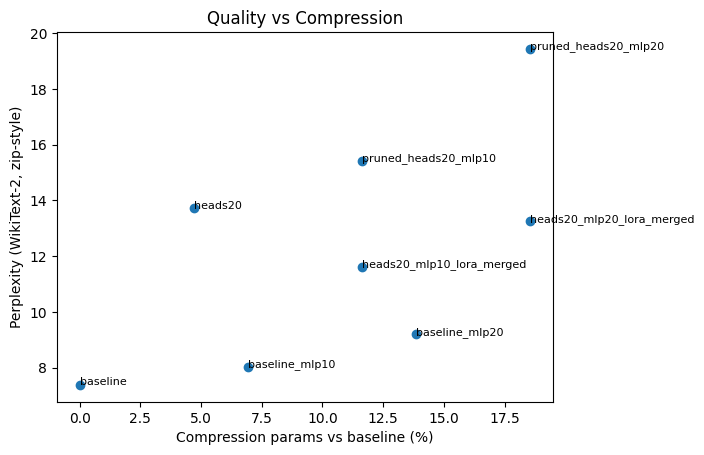

In [8]:
plt.figure()
x = df["params_compression_%"].values
y = df["ppl"].values
plt.scatter(x, y)
for _, r in df.iterrows():
    plt.text(r["params_compression_%"], r["ppl"], r["tag"], fontsize=8)
plt.xlabel("Compression params vs baseline (%)")
plt.ylabel("Perplexity (WikiText-2, zip-style)")
plt.title("Quality vs Compression")
plt.show()


Courbe 2 : Latence vs params

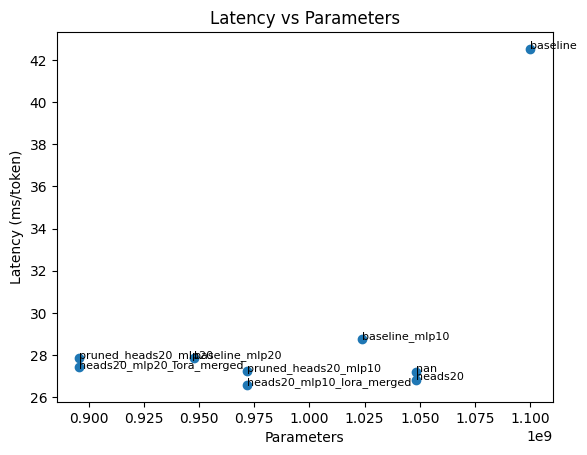

In [9]:
plt.figure()
x = df["params"].values
y = df["latency_ms_per_token"].values
plt.scatter(x, y)
for _, r in df.iterrows():
    plt.text(r["params"], r["latency_ms_per_token"], r["tag"], fontsize=8)
plt.xlabel("Parameters")
plt.ylabel("Latency (ms/token)")
plt.title("Latency vs Parameters")
plt.show()


Analyse rapide automatique (texte)

In [10]:
def best_by(metric, minimize=True):
    tmp = df.dropna(subset=[metric]).copy()
    if len(tmp) == 0:
        return None
    i = tmp[metric].idxmin() if minimize else tmp[metric].idxmax()
    return tmp.loc[i].to_dict()

best_ppl = best_by("ppl", minimize=True)
best_lat = best_by("latency_ms_per_token", minimize=True)

print("=== Quick Analysis ===")
if best_ppl:
    print(f"Best quality (lowest PPL): {best_ppl['tag']}  (PPL={best_ppl['ppl']:.3f})")
if best_lat:
    print(f"Fastest (lowest latency): {best_lat['tag']}  (lat={best_lat['latency_ms_per_token']:.2f} ms/token)")

# compare recovered vs pruned (simple pattern)
pruned = df[df["tag"].str.contains("pruned", case=False, regex=False)]
recovered = df[df["tag"].str.contains("lora_merged", case=False, regex=False)]

if len(pruned) and len(recovered):
    print("\nRecovered vs Pruned (mean):")
    print("PPL pruned mean:", pruned["ppl"].mean())
    print("PPL recovered mean:", recovered["ppl"].mean())


=== Quick Analysis ===
Best quality (lowest PPL): baseline  (PPL=7.382)
Fastest (lowest latency): heads20_mlp10_lora_merged  (lat=26.58 ms/token)


ValueError: Cannot mask with non-boolean array containing NA / NaN values